# Popular or Not?

In [1]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import imblearn.over_sampling 



In [2]:
with open('genre_df.pkl', 'rb') as f:
    genre_df = pickle.load(f)
    

In [3]:
genre_df.head()


,id,name,album,artists,artist_ids,explicit,danceability,energy,key,loudness,...,instrumentalness,liveness,valence,tempo,duration_ms,year,release_date,track_pop,artist_pop,genres
0,4llunZfVXv3NvUzXVB3VVL,Maria,The Battle Of Los Angeles,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],False,0.277,0.873,11,-6.571,...,0.000054,0.1880,0.618,172.848,228093,1999,1999-11-02,46.0,[71],"[[alternative metal, alternative rock, conscio..."
1,21Mq0NzFoVRvOmLTOnJjng,Voice of the Voiceless,The Battle Of Los Angeles,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],False,0.441,0.882,7,-7.363,...,0.006840,0.1500,0.418,83.371,151573,1999,1999-11-02,44.0,[71],"[[alternative metal, alternative rock, conscio..."
2,2LXPNLSMAauNJfnC58lSqY,Born of a Broken Man,The Battle Of Los Angeles,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],False,0.298,0.848,2,-5.947,...,0.001520,0.2010,0.194,148.282,280960,1999,1999-11-02,55.0,[71],"[[alternative metal, alternative rock, conscio..."
3,7o2Razxnl33Jrgz4PpMYNa,Ashes In the Fall,The Battle Of Los Angeles,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],True,0.456,0.704,7,-6.687,...,0.000004,0.0595,0.656,140.629,277267,1999,1999-11-02,43.0,[71],"[[alternative metal, alternative rock, conscio..."
4,3Hxu3Ey1TV9mZ5XqMXckiS,War Within a Breath,The Battle Of Los Angeles,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],False,0.399,0.965,6,-5.901,...,0.031400,0.3670,0.174,98.464,216427,1999,1999-11-02,44.0,[71],"[[alternative metal, alternative rock, conscio..."


In [4]:
genre_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37934 entries, 0 to 38999
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                37934 non-null  object 
 1   name              37934 non-null  object 
 2   album             37934 non-null  object 
 3   artists           37934 non-null  object 
 4   artist_ids        37934 non-null  object 
 5   explicit          37934 non-null  object 
 6   danceability      37934 non-null  float64
 7   energy            37934 non-null  float64
 8   key               37934 non-null  int64  
 9   loudness          37934 non-null  float64
 10  mode              37934 non-null  int64  
 11  speechiness       37934 non-null  float64
 12  acousticness      37934 non-null  float64
 13  instrumentalness  37934 non-null  float64
 14  liveness          37934 non-null  float64
 15  valence           37934 non-null  float64
 16  tempo             37934 non-null  float6

In [5]:
genre_df = genre_df.dropna()



### Track Popularity
The popularity of a track is a value between 0 and 100, with 100 being the most popular. The popularity is calculated by algorithm and is based, in the most part, on the total number of plays the track has had and how recent those plays are.

In [6]:
genre_df.track_pop.describe()



count    35060.000000
mean         7.145693
std         11.330565
min          0.000000
25%          0.000000
50%          2.000000
75%         10.000000
max         82.000000
Name: track_pop, dtype: float64

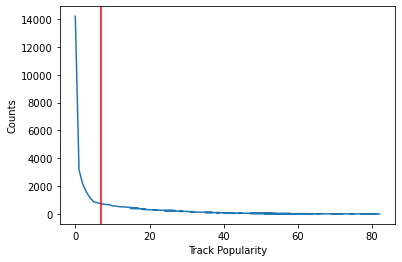

In [84]:
popularity = genre_df['track_pop']
plt.plot(popularity.value_counts())
plt.xlabel("Track Popularity")
plt.ylabel("Counts")
plt.axvline(x=7, color="red")

In [8]:
pop_cutoff = np.percentile(popularity, 70)

def is_popular(track):
    if track.track_pop >= pop_cutoff:
        track['is_popular'] = 1
    else:
        track['is_popular'] = 0
    return track


In [9]:
genre_df = genre_df.apply(is_popular, axis=1)


In [10]:
genre_df.is_popular.value_counts()


0    23893
1    11167
Name: is_popular, dtype: int64

## Baseline Logistic Regression Model 

In [11]:
X = genre_df.loc[:,'danceability':'artist_pop'].drop(['duration_ms','release_date','artist_pop', 'track_pop'], axis=1)
y = genre_df['is_popular']


In [12]:
X.head()


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,year
0,0.277,0.873,11,-6.571,0,0.0883,0.00694,0.000054,0.1880,0.618,172.848,1999
1,0.441,0.882,7,-7.363,1,0.0440,0.01950,0.006840,0.1500,0.418,83.371,1999
2,0.298,0.848,2,-5.947,1,0.0727,0.05380,0.001520,0.2010,0.194,148.282,1999
3,0.456,0.704,7,-6.687,1,0.0982,0.00520,0.000004,0.0595,0.656,140.629,1999
4,0.399,0.965,6,-5.901,1,0.1430,0.00442,0.031400,0.3670,0.174,98.464,1999


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=14, test_size=0.2)



In [14]:
y_test.value_counts()



0    4833
1    2179
Name: is_popular, dtype: int64

In [15]:
metrics = {}

def show_metrics(model, y_true, y_pred):
    conf_matrix = confusion_matrix(y_true = y_test, y_pred = y_pred)
    cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = [False, True])
    cm_display.plot()
    
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    
    metrics[model] = [precision, recall, f1, accuracy]
    print('Precision: %.3f' % precision)
    print('Recall: %.3f' % recall)
    print('F1: %.3f' % f1)
    print('Accuracy: %.3f' % accuracy)
    

Precision: 0.333
Recall: 0.000
F1: 0.001
Accuracy: 0.689


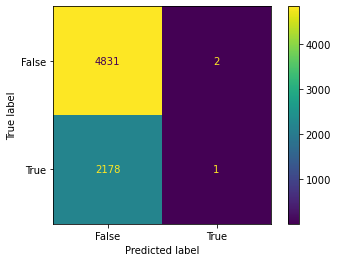

In [16]:
lr_model = LogisticRegression(C=100)
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)

show_metrics('Simple Logistic Regression', y_test, y_pred)

###### Observations: 
1. Y target is not normally distributed. It has a logarithmic curve 
2. The baseline predictions are only predicting 0/False because of heavy class imbalance in the dataset 

#### Handling class imbalance with Balanced weights 

Precision: 0.383
Recall: 0.681
F1: 0.490
Accuracy: 0.560


/Users/aanvigoel/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


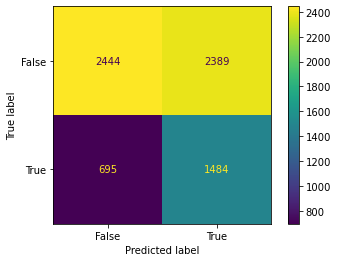

In [17]:
lr_balanced_model = LogisticRegression(C=1000, class_weight='balanced')
lr_balanced_model.fit(X_train, y_train)
y_pred = lr_balanced_model.predict(X_test)

show_metrics('Logistic Regression w/ Balanced Weights', y_test, y_pred)


#### Optimizing value of C for best fit Logistic Regression

In [18]:
parameters = {'C':[0.01, 0.1, 1, 10, 100, 1000]}

lr_cv_model = LogisticRegression(max_iter=10000, penalty='l2', class_weight='balanced')
cv = GridSearchCV(lr_cv_model, parameters)
cv.fit(X_train, y_train)
cv.best_params_


{'C': 100}

Precision: 0.383
Recall: 0.680
F1: 0.490
Accuracy: 0.560


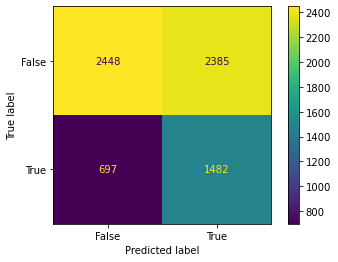

In [19]:
lr_opt = LogisticRegression(C=100, max_iter=10000, penalty='l2', class_weight='balanced')
lr_opt.fit(X_train, y_train)
y_pred = lr_opt.predict(X_test)

show_metrics('Optimized Logistic Regression', y_test, y_pred)



#### Resampling the data  

Precision: 0.395
Recall: 0.639
F1: 0.489
Accuracy: 0.584


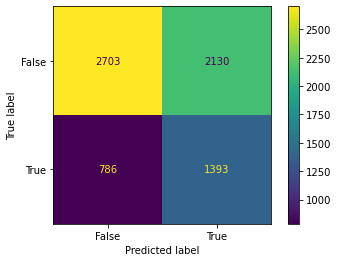

In [20]:
n_pos = np.sum(y_train == 1)
n_neg = np.sum(y_train == 0)
ratio = {1: n_pos*2, 0: n_neg}

#Oversample positive samples with a 2:1 ratio 
ROS = imblearn.over_sampling.RandomOverSampler(sampling_strategy=ratio, random_state=35)

X_train_os, y_train_os = ROS.fit_resample(X_train, y_train)

lr_os_model = LogisticRegression(C=100)
lr_os_model.fit(X_train_os, y_train_os)
y_pred = lr_os_model.predict(X_test)

show_metrics('Logistic Regression w/ OverSampling', y_test, y_pred)


Precision: 0.391
Recall: 0.611
F1: 0.477
Accuracy: 0.584


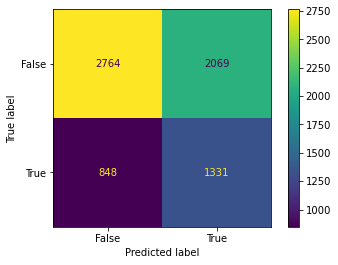

In [21]:
# Trying Resampling with SMOTE
smote = imblearn.over_sampling.SMOTE(sampling_strategy=ratio, random_state=35)

X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

lr_smote_model = LogisticRegression(C=100)
lr_smote_model.fit(X_train_smote, y_train_smote)
y_pred = lr_smote_model.predict(X_test)

show_metrics('Logistic Regression w/ SMOTE', y_test, y_pred)


Note: SMOTE gives the same performance as Oversampling

#### Adjusting Class Weights

Precision: 0.396
Recall: 0.642
F1: 0.490
Accuracy: 0.584


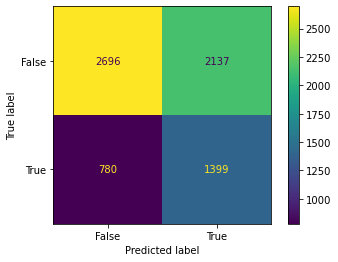

In [22]:
lr_cw = LogisticRegression(C=100, class_weight={1:2, 0:1})
lr_cw.fit(X_train, y_train)

y_pred = lr_cw.predict(X_test)
show_metrics('Logistic Regression w/ 2:1 Class Weights', y_test, y_pred)


Precision: 0.373
Recall: 0.722
F1: 0.492
Accuracy: 0.537


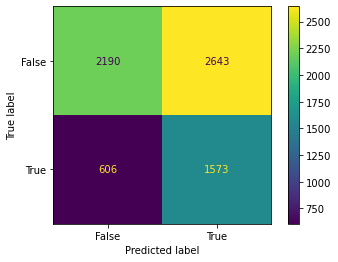

In [81]:
lr_cw_os = LogisticRegression(C=100, class_weight={1:1.15, 0:1})
lr_cw_os.fit(X_train_os, y_train_os)
y_pred = lr_cw_os.predict(X_test)

show_metrics('Logistic Regression w/ OS + Class Weights', y_test, y_pred)


###### Observations: 
- Adjusting class weights with a 1.15:1 ratio for the Logistic Regression gives the best performance so far

#### Finding Optimal Threshold p

In [82]:
%%capture --no-display

X_val, y_val = X_test, y_test

thresh_ps = np.linspace(0.1, 0.7, 1000)
model_val_probs = lr_cw_os.predict_proba(X_val)[:,1]

f1_scores, prec_scores, rec_scores, acc_scores = [], [], [] , []
for p in thresh_ps:
    model_val_labels = model_val_probs>=p
    f1_scores.append(f1_score(y_val, model_val_labels))
    prec_scores.append(precision_score(y_val, model_val_labels))
    rec_scores.append(recall_score(y_val, model_val_labels))
    acc_scores.append(accuracy_score(y_val, model_val_labels))

In [25]:
best_f1_score = np.max(f1_scores) 
best_thresh_p = thresh_ps[np.argmax(f1_scores)]
print('Best F1 score %.3f at prob decision threshold >= %.3f' 
      % (best_f1_score, best_thresh_p))

best_prec_score = np.max(prec_scores) 
best_thresh_p2 = thresh_ps[np.argmax(prec_scores)]
print('Best Precision score %.3f at prob decision threshold >= %.3f' 
      % (best_prec_score, best_thresh_p2))

Best F1 score 0.499 at prob decision threshold >= 0.472
Best Precision score 1.000 at prob decision threshold >= 0.693


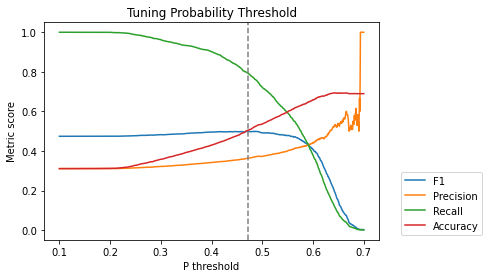

In [83]:
plt.plot(thresh_ps, f1_scores)
plt.plot(thresh_ps, prec_scores)
plt.plot(thresh_ps, rec_scores)
plt.plot(thresh_ps, acc_scores)

plt.title('Tuning Probability Threshold')
plt.legend(['F1','Precision','Recall','Accuracy'], bbox_to_anchor=(1.05, 0), loc='lower left')
plt.xlabel('P threshold')
plt.ylabel('Metric score')

plt.axvline(x=0.472, color='grey', linestyle='--')

### Baseline LR Model: With Oversampling + Class Weight Adjustment + Tuning Decision Threshold

Precision: 0.364
Recall: 0.793
F1: 0.499
Accuracy: 0.505


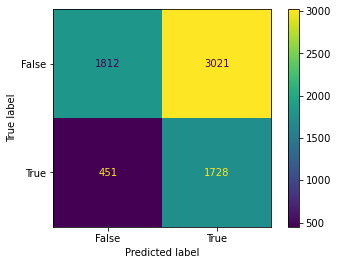

In [26]:
y_pred_new_threshold = (lr_cw_os.predict_proba(X_test)[:,1]>=0.472).astype(int)

show_metrics('Baseline: Logistic Regression + Handling Class Imbalance', y_test, y_pred_new_threshold)

In [27]:
pd.DataFrame(data=np.column_stack((X.columns, ((np.exp(lr_cw_os.coef_[0])-1)*100))), columns=['Features','% Odds'])


,Features,% Odds
0,danceability,66.543911
1,energy,-9.528595
2,key,0.3107
3,loudness,2.308803
4,mode,-8.048337
5,speechiness,-18.082337
6,acousticness,-47.848309
7,instrumentalness,-40.08758
8,liveness,-4.445637
9,valence,18.8713


### Decision Tree Classifier

Precision: 0.451
Recall: 0.476
F1: 0.463
Accuracy: 0.657


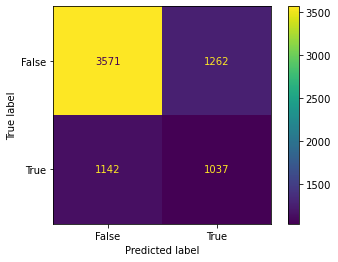

In [28]:
dt_classifier = DecisionTreeClassifier(random_state = 53)
dt_classifier.fit(X_train, y_train)
y_pred = dt_classifier.predict(X_test)

show_metrics('Decision Tree', y_test, y_pred)


### Random Forest

Precision: 0.614
Recall: 0.320
F1: 0.421
Accuracy: 0.726


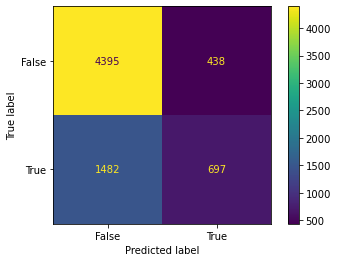

In [29]:
rf_classifier = RandomForestClassifier(n_estimators = 10, random_state = 10)
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)

show_metrics('Base Random Forest', y_test, y_pred)



#### Optimizing RF

In [30]:
%%capture --no-display

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num =10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10,100,num=10)]
min_samples_split = [2,5,10]
min_samples_leaf = [1,2,4]
bootstrap =[True, False]


random_grid = { 'n_estimators': n_estimators,
               'max_features': max_features, 
               'max_depth': max_depth, 
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap
              }

rf_random = RandomizedSearchCV(estimator = RandomForestClassifier(), param_distributions = random_grid, 
                               n_iter = 100, cv = 3, verbose = 2, random_state = 46, n_jobs = -1)
rf_random.fit(X_train, y_train)



/Users/aanvigoel/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/aanvigoel/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/aanvigoel/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove thi

[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=800; total time=  39.3s
[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1800; total time= 2.5min


/Users/aanvigoel/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/aanvigoel/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/aanvigoel/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove thi

[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=800; total time=  39.3s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1800; total time= 1.5min
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=  52.8s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=800; total time= 1.1min
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  11.5s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1800; total time= 2.6min


/Users/aanvigoel/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/aanvigoel/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=  47.5s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=  48.7s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=  51.4s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=  23.1s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=  24.0s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1400; total time= 1.3min
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1800; total time= 2.6min


/Users/aanvigoel/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/aanvigoel/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/aanvigoel/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove thi

[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=1400; total time= 1.3min
[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1800; total time= 1.8min
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=2000; total time= 2.0min


/Users/aanvigoel/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/aanvigoel/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/aanvigoel/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove thi

[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=800; total time=  39.7s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1800; total time= 1.5min
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=  52.9s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=800; total time= 1.1min
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  11.4s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  12.5s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=2000; total time= 1.9min
[CV] END bootstrap=False, max_depth=50

/Users/aanvigoel/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/aanvigoel/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/aanvigoel/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove thi

[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=600; total time=  48.8s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1000; total time= 1.4min
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1800; total time= 1.8min
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1600; total time= 1.5min
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1600; total time= 2.5min


/Users/aanvigoel/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/aanvigoel/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/aanvigoel/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove thi

[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1800; total time= 2.4min
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time= 1.4min
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1400; total time= 2.0min
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=2000; total time= 1.9min
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1000; total time= 1.4min
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1400; total time= 1.5min
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=2000; total time= 2.0min
[CV] END bootstrap=False, max_dep

/Users/aanvigoel/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/aanvigoel/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/aanvigoel/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove thi

[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=1600; total time= 1.1min
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time= 1.8min


/Users/aanvigoel/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/aanvigoel/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/aanvigoel/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove thi

[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=800; total time= 1.1min
[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=2000; total time= 1.9min
[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=2000; total time= 2.1min
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=800; total time= 1.1min
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1600; total time= 1.5min
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1600; total time= 1.5min
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time= 1.8min
[CV] END bootstrap=True, max_depth=20,

/Users/aanvigoel/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/aanvigoel/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/aanvigoel/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove thi

[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=  48.3s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=  49.5s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=  52.3s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=  23.1s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=800; total time= 1.1min
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1400; total time= 2.1min
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time= 1.5min
[CV] END bootstrap=False, max_depth=

/Users/aanvigoel/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/aanvigoel/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/aanvigoel/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove thi

[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1000; total time= 1.0min
[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time= 3.2min


/Users/aanvigoel/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/aanvigoel/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/aanvigoel/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove thi

[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1800; total time= 2.4min
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time= 1.4min
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1400; total time= 2.1min
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time= 1.5min
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=600; total time=  49.2s
[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1800; total time= 1.9min
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1600; total time= 1.5min
[CV] END bootstrap=False, max_dept

/Users/aanvigoel/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/aanvigoel/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/aanvigoel/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove thi

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=46, verbose=2)

In [31]:
rf_random.best_params_


{'n_estimators': 1800,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 70,
 'bootstrap': False}

In [32]:
best_rf = rf_random.best_estimator_
y_pred = best_rf.predict(X_test)


Precision: 0.678
Recall: 0.389
F1: 0.494
Accuracy: 0.753


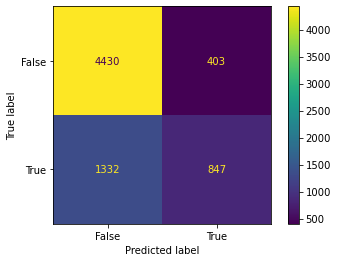

In [33]:
show_metrics('Optimized Random Forest', y_test, y_pred)



### XGBoost

In [34]:
xg_classifier = XGBClassifier(seed = 14)

params={ 'n_estimators' : [100, 500, 1000],
         'max_depth': [3,6,10], 
         'colsample_bylevel': [0.4, 0.8],
         'learning_rate':[0.01, 0.05, 0.1]}


clf = GridSearchCV(estimator = xg_classifier, 
                  param_grid=params, 
                  scoring='neg_root_mean_squared_error',
                  verbose=1)

clf.fit(X_train, y_train)


Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1600; total time= 2.7min
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=  19.6s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1400; total time= 1.3min
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1400; total time= 1.4min
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1200; total time= 2.0min
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1400; total time= 1.3min
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimator

[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1600; total time= 2.5min
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=  19.3s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=2000; total time= 2.1min
[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=800; total time=  46.4s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=600; total time=  23.5s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=600; total time=  23.7s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1200; total time= 1.1min
[CV] END bootstrap=False, max_depth=100, m

[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=2000; total time= 3.1min
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=2000; total time= 1.5min
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=2000; total time= 2.0min
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time= 1.6min
[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=400; total time=  22.9s
[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=400; total time=  23.0s
[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1400; total time= 1.3min
[CV] END bootstrap=True, max_depth=90, 

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_to_...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, ...),
             param_grid={'colsample_bylevel': [0.4, 0.8],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 6, 10],
                         'n_estimators': [100, 500, 1000]},
             scoring='neg_root_mean_squared_error', verbose=1)

In [35]:
print("Best parameters:", clf.best_params_)

Best parameters: {'colsample_bylevel': 0.4, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 1000}


Precision: 0.660
Recall: 0.376
F1: 0.479
Accuracy: 0.746


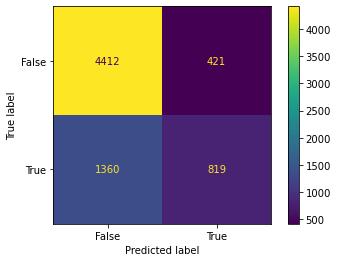

In [36]:
best_xg = clf.best_estimator_
y_pred = best_xg.predict(X_test)

show_metrics('XGBoost', y_test, y_pred)

### Model Comparison

In [37]:
pd.DataFrame.from_dict(metrics, orient='index', columns=['Precision', 'Recall', 'F1', 'Accuracy'])



,Precision,Recall,F1,Accuracy
Simple Logistic Regression,0.333333,0.000459,0.000917,0.689104
Logistic Regression w/ Balanced Weights,0.383166,0.681046,0.490416,0.560183
Optimized Logistic Regression,0.383243,0.680128,0.490241,0.560468
Logistic Regression w/ OverSampling,0.395402,0.639284,0.488600,0.584141
Logistic Regression w/ SMOTE,0.391471,0.610831,0.477146,0.583999
Logistic Regression w/ 2:1 Class Weights,0.395645,0.642038,0.489589,0.583999
Logistic Regression w/ OS + Class Weights,0.373102,0.721891,0.491947,0.536651
Baseline: Logistic Regression + Handling Class Imbalance,0.363866,0.793024,0.498845,0.504849
Decision Tree,0.451066,0.475906,0.463153,0.657159
Base Random Forest,0.614097,0.319872,0.420640,0.726184


### Diving into the Final Model

In [38]:
# Optimized Random Forest - Balances the Precision and Recall values while favoring the Precision. 
# We want to reduce the False positive predictions to ensure we are not marking unpopular tracks as popular  

In [39]:
importances = best_rf.feature_importances_

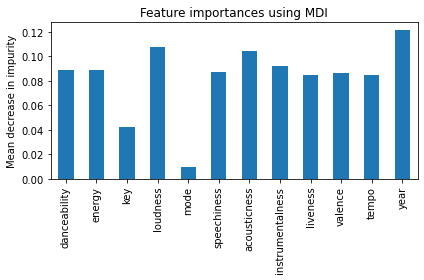

In [42]:
forest_importances = pd.Series(importances, index=X.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()